In [78]:
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import xxhash
import os

In [50]:
Result = namedtuple("Result", ["count", "maxlen_lo", "maxlen_hi", "t"])
IterInfo = namedtuple("IterInfo", ["cnt_seqs", "rap_lo", "rap_hi"])

In [65]:
MISC_SAVES = "/home/vlad/Documents/SublimeMerge/ExpoSizeStringSearch/llm_intersection_local/intersection_test_files/misc_saves"
SERVER_SAVES = "/home/vlad/Desktop/Probleme/E3S/llm_intersection/server_intersection/E3S_sawn_off/parquet_outputs/"
# CNT_BYTES_ATTACK = 250 * (50 << 20)
# CNT_WANTED_BYTES_ATTACK = 1024 * (50 << 20)
# CNT_BYTES_PER_FILE = 50 * (50 << 20)

CNT_BYTES_PER_FILE = 50 * (1 << 20)
CNT_BYTES_ATTACK = 5 * CNT_BYTES_PER_FILE
CNT_WANTED_BYTES_ATTACK = 20 * CNT_BYTES_PER_FILE

In [66]:
def get_results_from_file(fname):
    results = []
    with open(fname, "rb") as fin:
        lines = list(fin.readlines())
        i = 0
        while i < len(lines):
            count, maxlen_lo, maxlen_hi = map(
                lambda x: int(x.split('=')[-1]),
                lines[i].decode("utf-8").strip().replace(' ', '').split(',')
            )
            t, len_t = [], 0
            j = i + 1
            while j < len(lines) and len_t <= maxlen_lo: # <= ptc am bonus ultimul endl.
                t.append(lines[j])
                len_t += len(lines[j])
                j += 1
            i = j + 1 # sar peste "---"
            results.append(Result(count, maxlen_lo, maxlen_hi, b''.join(t)[:-1]))
            
    return results

In [88]:
# base_pq
results = get_results_from_file(f"{MISC_SAVES}/output4_inter_bs.txt")
print(f"{len(results) = }")

hashes = set()
cnt_gen_lo, cnt_gen_hi = 0, 0
str_lens = []
for r in results:
    hh = xxhash.xxh64(r.t).hexdigest()
    cnt_useless = sum([r.t.count(ch) for ch in [b' ', b'-', b'.']])
    if hh not in hashes and cnt_useless < len(r.t):
        hashes.add(hh)
        cnt_gen_lo += r.maxlen_lo * r.count
        cnt_gen_hi += r.maxlen_hi * r.count
        str_lens.append(len(r.t))
        
print(f"{cnt_gen_lo = }, {cnt_gen_hi = }")
print(f"% lo = {round(cnt_gen_lo / CNT_BYTES_ATTACK * 100, 4)}, % hi = {round(cnt_gen_hi / CNT_BYTES_ATTACK * 100, 4)}")
print(f"approx no. of unique generated sequences of >= 50 tokens at {CNT_WANTED_BYTES_ATTACK} bytes: {CNT_WANTED_BYTES_ATTACK // CNT_BYTES_ATTACK * len(hashes)}")

len(results) = 131566
cnt_gen_lo = 71566803, cnt_gen_hi = 74178526
% lo = 27.3006, % hi = 28.2969
approx no. of unique generated sequences of >= 50 tokens at 1048576000 bytes: 164444


Text(0, 0.5, '# distinct extracted sequences\n>= 50 tokens')

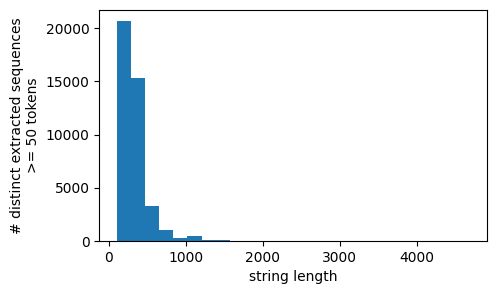

In [89]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.stairs(*np.histogram(str_lens, bins = 25), fill = True)
ax.set_xlabel("string length")
ax.set_ylabel("# distinct extracted sequences\n>= 50 tokens")

In [61]:
# iter_attack_pq
cnt_iters = 18
iter_out = []

hashes = set()
cnt_gen_lo, cnt_gen_hi = 0, 0
for i in range(cnt_iters):
    for r in get_results_from_file(f"{SERVER_SAVES}/output4_iter_attack_{i}.txt"):
        hh = xxhash.xxh64(r.t).hexdigest()
        cnt_useless = sum([r.t.count(ch) for ch in [b' ', b'-', b'.']])
        if hh not in hashes and cnt_useless < len(r.t):
            hashes.add(hh)
            cnt_gen_lo += r.count * r.maxlen_lo
            cnt_gen_hi += r.count * r.maxlen_hi
    iter_out.append(IterInfo(len(hashes), cnt_gen_lo / ((i+1) * CNT_BYTES_PER_FILE) * 100, cnt_gen_hi / ((i+1) * CNT_BYTES_PER_FILE) * 100))
    print(f"{i+1}/{cnt_iters}")

1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
18/18


In [62]:
iter_out

[IterInfo(cnt_seqs=15221, rap_lo=19.757221221923828, rap_hi=20.53306007385254),
 IterInfo(cnt_seqs=27531, rap_lo=17.964468002319336, rap_hi=18.562565803527832),
 IterInfo(cnt_seqs=38011, rap_lo=15.825146993001301, rap_hi=16.36890474955241),
 IterInfo(cnt_seqs=47746, rap_lo=14.06722116470337, rap_hi=14.56664991378784),
 IterInfo(cnt_seqs=56368, rap_lo=14.336555480957031, rap_hi=14.803304672241211),
 IterInfo(cnt_seqs=64061, rap_lo=13.083194414774576, rap_hi=13.513742764790853),
 IterInfo(cnt_seqs=72026, rap_lo=12.336818150111608, rap_hi=12.74441146850586),
 IterInfo(cnt_seqs=79314, rap_lo=11.887763500213623, rap_hi=12.282347202301025),
 IterInfo(cnt_seqs=87233, rap_lo=11.410679075453016, rap_hi=11.794608857896593),
 IterInfo(cnt_seqs=95921, rap_lo=10.972521209716797, rap_hi=11.34116725921631),
 IterInfo(cnt_seqs=102449, rap_lo=10.806587912819603, rap_hi=11.169757669622248),
 IterInfo(cnt_seqs=107979, rap_lo=10.31333335240682, rap_hi=10.672217051188152),
 IterInfo(cnt_seqs=114875, rap_lo

Text(0, 0.5, '# distinct extracted sequences\n>= 50 tokens')

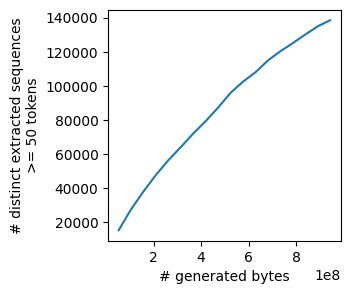

In [72]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.plot([(i+1) * CNT_BYTES_PER_FILE for i in range(len(iter_out))], [it.cnt_seqs for it in iter_out])

ax.set_xlabel("# generated bytes")
ax.set_ylabel("# distinct extracted sequences\n>= 50 tokens")